# Modeling and Evaluation

## Objectives

Business Requirements # 2 - The clients wants to know if the cherry leaf in the picture is healthy or if it has powdery mildew.

## Inputs

* `/data/cherry-leaves/train`
* `/data/cherry-leaves/test`
* `/data/cherry-leaves/validation`

## Outputs

* Images distribution plot in train, validation, and test set.
* Image augmentation.
* Class indices for prediction inference.
* Machine learning model creation and training.
* Model saved as `mildew_detection_model.h5`.
* Learning curve plot for model performance.
* Model evaluation pickle file.
* Prediction on a random image file.

### Change working directory

In [1]:
import os

current_dir = os.getcwd()
print(current_dir)

os.chdir(os.path.dirname(current_dir))
print("New working directory set.")

current_dir = os.getcwd()
print(current_dir)

/workspaces/mildew-detection-in-cherry-leaves/jupyter_notebooks
New working directory set.
/workspaces/mildew-detection-in-cherry-leaves


In [2]:
### Import packages

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
import joblib
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

2025-03-03 11:33:45.659272: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-03 11:33:45.676015: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-03 11:33:45.867165: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-03 11:33:45.960630: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741001626.103745   88761 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741001626.13

In [3]:
# ### Set input directories

my_data_dir = 'data/cherry-leaves'
train_path = os.path.join(my_data_dir, 'train')
val_path = os.path.join(my_data_dir, 'validation')
test_path = os.path.join(my_data_dir, 'test')

In [4]:
# ### Set output directories

version = 'v2'
file_path = os.path.join('outputs', version)

if 'outputs' in os.listdir(current_dir) and version in os.listdir(os.path.join(current_dir, 'outputs')):
    print('Old version exists. Creating a new version.')
else:
    os.makedirs(file_path, exist_ok=True)

Old version exists. Creating a new version.


In [5]:
# ### Set labels

labels = os.listdir(train_path)
print(f"Image Labels: {labels}")

# ### Set image shape

image_shape = joblib.load(filename=os.path.join('outputs', 'v1', 'image_shape.pkl')) # Promijenjeno na 'v1'
print(image_shape)

Image Labels: ['powdery_mildew', 'healthy']
(256, 256, 3)


* train - powdery_mildew: 1472 images
* train - healthy: 1472 images
* validation - powdery_mildew: 315 images
* validation - healthy: 315 images
* test - powdery_mildew: 317 images
* test - healthy: 317 images




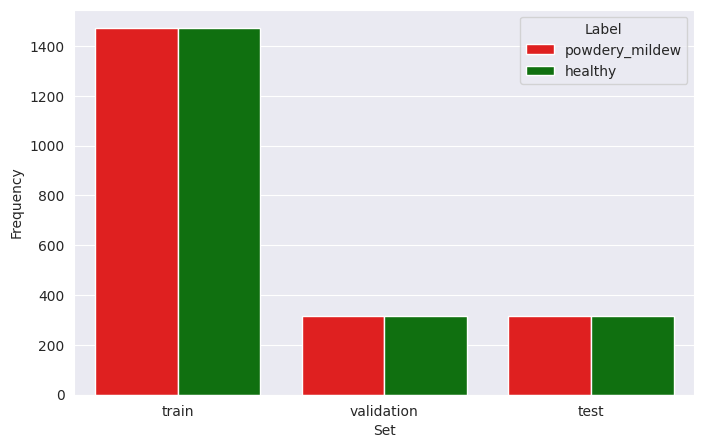

In [6]:
### Count images in train, validation, and test data

# Initialize the DataFrame
df_freq = pd.DataFrame(columns=['Set', 'Label', 'Frequency'])

# Count images in each set and for each label
for folder in ['train', 'validation', 'test']:
    for label in labels:
        folder_path = os.path.join(my_data_dir, folder, label)
        frequency = len(os.listdir(folder_path))

        new_row = pd.DataFrame([{'Set': folder, 'Label': label, 'Frequency': frequency}])
        df_freq = pd.concat([df_freq, new_row], ignore_index=True)

        print(f"* {folder} - {label}: {frequency} images")
print("\n")

# Set the style of the plot
sns.set_style("darkgrid")

# Define a custom color palette
palette = {"powdery_mildew": "red", "healthy": "green"}

# Generate the bar plot with the custom color palette
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label', palette=palette)

# Save and display the plot
plt.savefig(os.path.join(file_path, 'labels_distribution.png'), bbox_inches='tight', dpi=150)
plt.show()

In [8]:
### Image data augmentation

augmented_image_data = ImageDataGenerator(rotation_range=30,
                                          width_shift_range=0.15,
                                          height_shift_range=0.15,
                                          shear_range=0.2,
                                          zoom_range=0.2,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255)

batch_size = 5
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True)
print(train_set.class_indices)

validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False)
print(validation_set.class_indices)

test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False)
print(test_set.class_indices)

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}
Found 630 images belonging to 2 classes.
{'healthy': 0, 'powdery_mildew': 1}
Found 634 images belonging to 2 classes.
{'healthy': 0, 'powdery_mildew': 1}


Image batch shape: (5, 256, 256, 3)


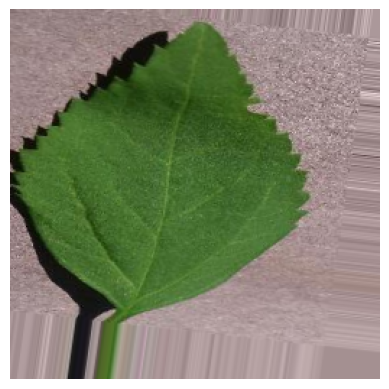

Image batch shape: (5, 256, 256, 3)


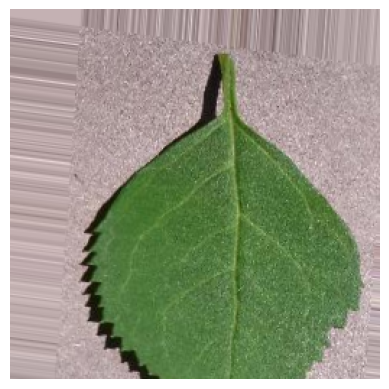

Image batch shape: (5, 256, 256, 3)


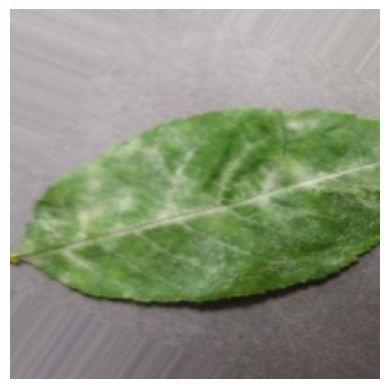

Image batch shape: (5, 256, 256, 3)


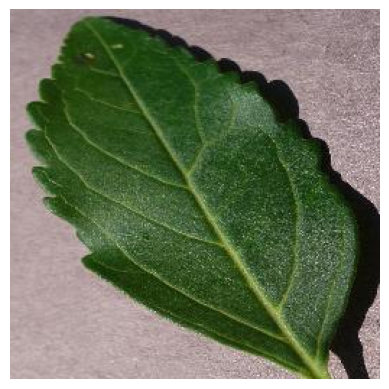

Image batch shape: (5, 256, 256, 3)


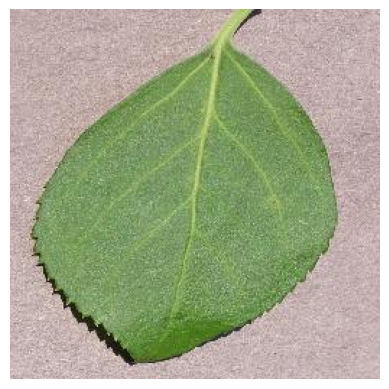

Image batch shape: (5, 256, 256, 3)


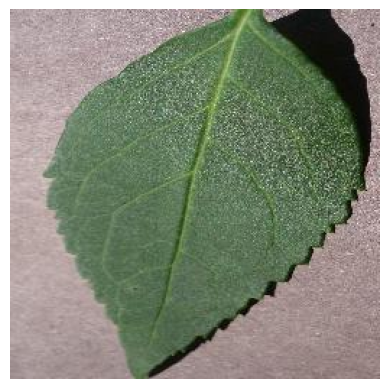

Image batch shape: (5, 256, 256, 3)


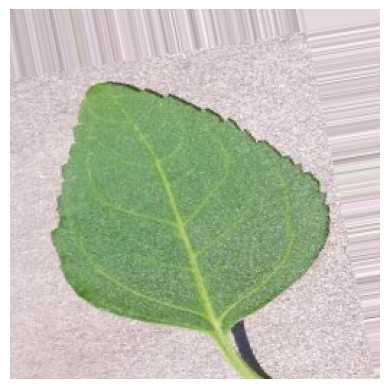

Image batch shape: (5, 256, 256, 3)


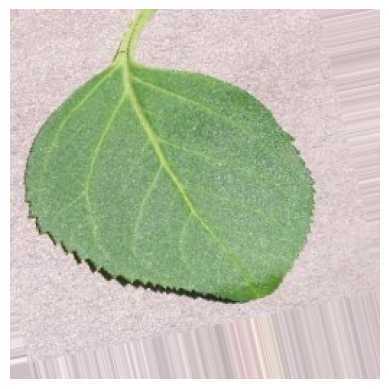

Image batch shape: (5, 256, 256, 3)


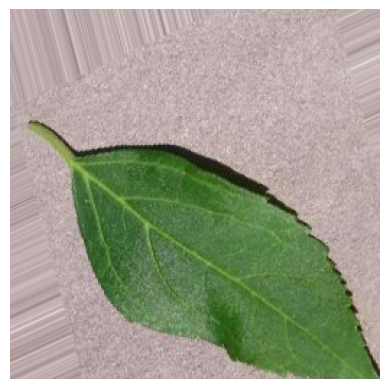

In [9]:
### Plot augmented training images

for _ in range(3):
    img, label = next(train_set)
    print(f"Image batch shape: {img.shape}")
    plt.imshow(img[0])
    plt.axis('off')  # Turn off axis display
    plt.show()

# ### Plot augmented validation images

for _ in range(3):
    img, label = next(validation_set)
    print(f"Image batch shape: {img.shape}")
    plt.imshow(img[0])
    plt.axis('off')  # Turn off axis display
    plt.show()

# ### Plot augmented test images

for _ in range(3):
    img, label = next(train_set)
    print(f"Image batch shape: {img.shape}")
    plt.imshow(img[0])
    plt.axis('off')  # Turn off axis display
    plt.show()

In [10]:
from tensorflow.keras.layers import Input

def create_tf_model():
    model = Sequential()
    model.add(Input(shape=image_shape))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.6))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Create the model
model = create_tf_model()

# Print the model summary
model.summary()

2025-03-03 11:35:22.569059: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,711,793 (14.16 MB)

 Trainable params: 3,711,793 (14.16 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
### Early stopping

early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
### Fit the model

model = create_tf_model()
history = model.fit(
    train_set,
    epochs=25,
    steps_per_epoch=train_set.samples // batch_size,
    validation_data=validation_set,
    callbacks=[early_stop],
    verbose=1,
)

Epoch 1/25


/home/cistudent/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


588/588 ━━━━━━━━━━━━━━━━━━━━ 141s 236ms/step - accuracy: 0.6621 - loss: 0.5745 - val_accuracy: 0.9667 - val_loss: 0.0885
Epoch 2/25
  1/588 ━━━━━━━━━━━━━━━━━━━━ 1:44 179ms/step - accuracy: 1.0000 - loss: 0.0413

/home/cistudent/.local/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


588/588 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 1.0000 - loss: 0.0413 - val_accuracy: 0.9810 - val_loss: 0.0721
Epoch 3/25
588/588 ━━━━━━━━━━━━━━━━━━━━ 138s 235ms/step - accuracy: 0.9478 - loss: 0.1326 - val_accuracy: 0.9810 - val_loss: 0.0694
Epoch 4/25
588/588 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9651 - val_loss: 0.1005
Epoch 5/25
588/588 ━━━━━━━━━━━━━━━━━━━━ 195s 235ms/step - accuracy: 0.9593 - loss: 0.1140 - val_accuracy: 0.9302 - val_loss: 0.1418
Epoch 6/25
588/588 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 1.0000 - loss: 0.0274 - val_accuracy: 0.9397 - val_loss: 0.1201
Epoch 7/25


In [ ]:
### Save Model
model.save(os.path.join(file_path, 'mildew_detection_model.h5'))

In [ ]:
## Model Performance

### Model learning curve
losses = pd.DataFrame(model.history.history)
sns.set_style("darkgrid")
losses[['loss','val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(os.path.join(file_path, 'model_training_losses.png'), bbox_inches='tight', dpi=150)
plt.show()

losses[['accuracy','val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(os.path.join(file_path, 'model_training_acc.png'), bbox_inches='tight', dpi=150)
plt.show()

In [ ]:
### Model Evaluation

### Load saved model
model = load_model(os.path.join(file_path, 'mildew_detection_model.h5'))

In [ ]:
### Evaluate model on test set.
evaluation = model.evaluate(test_set)
print(evaluation)

In [ ]:
### Save evaluation pickle
joblib.dump(value=evaluation, filename=os.path.join(file_path, 'evaluation.pkl'))


In [ ]:
## Predict on new data

### Load a random image as PIL
pointer = 66
label = labels[1]
pil_image = image.load_img(os.path.join(test_path, label, os.listdir(os.path.join(test_path, label))[pointer]),
                          target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0) / 255
print(my_image.shape)

In [ ]:
### Predict class probabilities
pred_proba = model.predict(my_image)[0, 0]
target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]
if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba
print(pred_proba)
print(pred_class)